<div id='header'>
    <div>
        <h1>Notebook - Argentina Provinces</h1>
        <p>Welcome to my notebook about analysis Argentina Provinces</p>
        Created by Luciano Rocchetta
    </div>
    <img src="./sources/argentina.jpg">
</div>

<h2>Setup</h2>

In [126]:
import pandas as pd
import geopandas as gpd
import requests
from shapely import Point, Polygon
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

# Setting seaborn config
sns.set_style("dark")

# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom/custom.css", "r").read()
    return HTML(f'<style>{styles}</style>')
css_styling()

<h3>Dataset Information</h3>
This dataset has information about the different provinces of Argentina.

- Year: 2020

<h3>Columns Information</h3>

- Province: Province's name.
- gdp: Gross domestic product per dollar.
- illiteracy: Rate of uneducated population.
- poverty: Poverty rate
- deficient_infra: Lack of infrastructure.
- school_dropout: School dropout rate.
- no_healthcare: No health care rate.
- birth_mortal: Birth mortality.
- pop: Population quantity.
- movie_theatres_per_cap: Movie Theatres Available (?).
- doctors_per_cap: Doctors available per cap

In [127]:
df = pd.read_csv('./argentina.csv')

<h2>1. Data Exploration</h2>

In [128]:
df.head(n=10)

,province,gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,movie_theatres_per_cap,doctors_per_cap
0,Buenos Aires,292689867.99,1.38,8.17,5.51,0.77,48.79,4.40,15625084,0.00,0.00
1,Catamarca,6150949.16,2.34,9.23,10.46,0.95,45.05,1.50,367828,0.00,0.00
2,Córdoba,69363739.19,2.71,5.38,10.44,1.04,45.76,4.80,3308876,0.00,0.01
3,Corrientes,7968012.98,5.60,12.75,17.44,3.86,62.11,5.90,992595,0.00,0.00
4,Chaco,9832642.67,7.52,15.86,31.48,2.58,65.51,7.50,1055259,0.00,0.00
5,Chubut,17747854.21,1.55,8.05,8.04,0.59,39.55,3.00,509108,0.00,0.00
6,Entre Ríos,20743409.10,3.19,7.29,18.79,1.89,48.66,3.10,1235994,0.00,0.00
7,Formosa,3807057.42,4.61,17.04,28.00,2.27,65.81,16.20,530162,0.00,0.00
8,Jujuy,6484938.33,2.15,13.37,12.48,0.72,54.16,3.70,673307,0.00,0.00
9,La Pampa,6990262.46,1.54,3.40,16.51,0.20,45.48,7.20,318951,0.00,0.01


In [129]:
print(f"Dataframe shape: Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Dataframe shape: Rows: 22, Columns: 11


In [130]:
df.columns

Index(['province', 'gdp', 'illiteracy', 'poverty', 'deficient_infra',
       'school_dropout', 'no_healthcare', 'birth_mortal', 'pop',
       'movie_theatres_per_cap', 'doctors_per_cap'],
      dtype='object')

<h3>1.1 Drop columns</h3>

Dropping movie_theatres_per_cap. This variable is not important in my analysis.

In [131]:
df = df.drop(columns=['movie_theatres_per_cap'])

<h3>1.2 Columns</h3>

In [132]:
categorical_columns = df.select_dtypes(include='object')
numerical_columns = df.select_dtypes(exclude='object')

print(f"""
Number of categorical_columns: {len(categorical_columns.columns)}
Number of numerical_columns: {len(numerical_columns.columns)}
""")


Number of categorical_columns: 1
Number of numerical_columns: 9



<h3>1.3 Statistics on numerical columns</h3>

In [133]:
numerical_columns.describe()

,gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,doctors_per_cap
count,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00
mean,30557027.88,3.23,9.93,12.68,1.72,50.77,4.99,1686351.82,0.00
std,61830995.40,1.85,3.78,7.22,1.15,9.18,3.50,3219827.99,0.00
min,3807057.42,0.79,3.40,3.84,0.20,29.23,0.80,273964.00,0.00
25%,8041586.88,1.99,7.47,7.57,0.81,45.55,3.02,514371.50,0.00
50%,10964161.23,2.74,9.14,10.87,1.44,49.37,4.00,777530.50,0.00
75%,19994520.37,3.69,12.50,16.10,2.51,56.92,5.88,1230605.75,0.01
max,292689867.99,7.52,17.04,31.48,3.86,65.81,16.20,15625084.00,0.01


<h3>1.4 Missing values</h3>

The dataset has not missing values

In [134]:
df.isnull().sum()

province           0
gdp                0
illiteracy         0
poverty            0
deficient_infra    0
school_dropout     0
no_healthcare      0
birth_mortal       0
pop                0
doctors_per_cap    0
dtype: int64

<h2>2. Data Engineering</h2>

<h3>2.1 GDP per capita</h3>

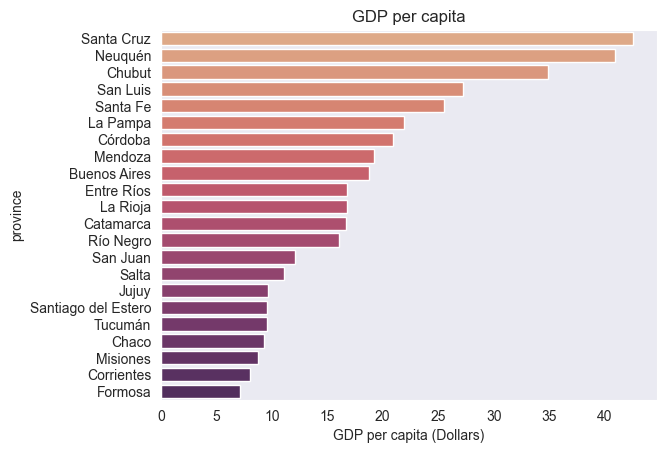

In [135]:
df['gdp_per_capita'] = df['gdp'] / df['pop']

sns.barplot(
    data = df.loc[:, ['province', 'gdp_per_capita']].sort_values(by='gdp_per_capita', ascending=False), 
    legend=False,
    x='gdp_per_capita',
    y='province',
    hue='province',
    orient='h',
    palette='flare'
)

plt.title("GDP per capita")
plt.xlabel("GDP per capita (Dollars)")
plt.show()

<h3>2.2 Top 5 bad provinces in each numerical variable</h3>

In [136]:
def create_graphic_grid(df: pd.DataFrame, 
                        variables: list,
                        fixed_variable = None,
                        ascending = False):
    """
        Definition: 
        Function to create dynamically the barplot graphics of each numerical variable 
        in the dataset.

        Parameters:
        df (pd.DataFrame): DataFrame of provinces. 
        variables (list): Numerical variables.
        fixed_variable (str): Y-axis on the graphic.
        ascending (Boolean): Sort order.
        
    """
    rows_size = 2
    columns_size = int(len(variables) / rows_size)
    
    fig, ax = plt.subplots(rows_size, columns_size, figsize=(20,10))

    # Add graphics to axis
    column_index = 0
    row_index = 0
    for variable in variables:
        temp_df = df[[fixed_variable, variable]].sort_values(by=variable, ascending=ascending).iloc[:5]
        sns.barplot(ax=ax[row_index][column_index], 
                         x=temp_df[fixed_variable],
                         y=temp_df[variable],
                         hue=temp_df[variable]
                        )
        if column_index == columns_size - 1:
             column_index = 0
             row_index += 1
        else:
            column_index += 1 

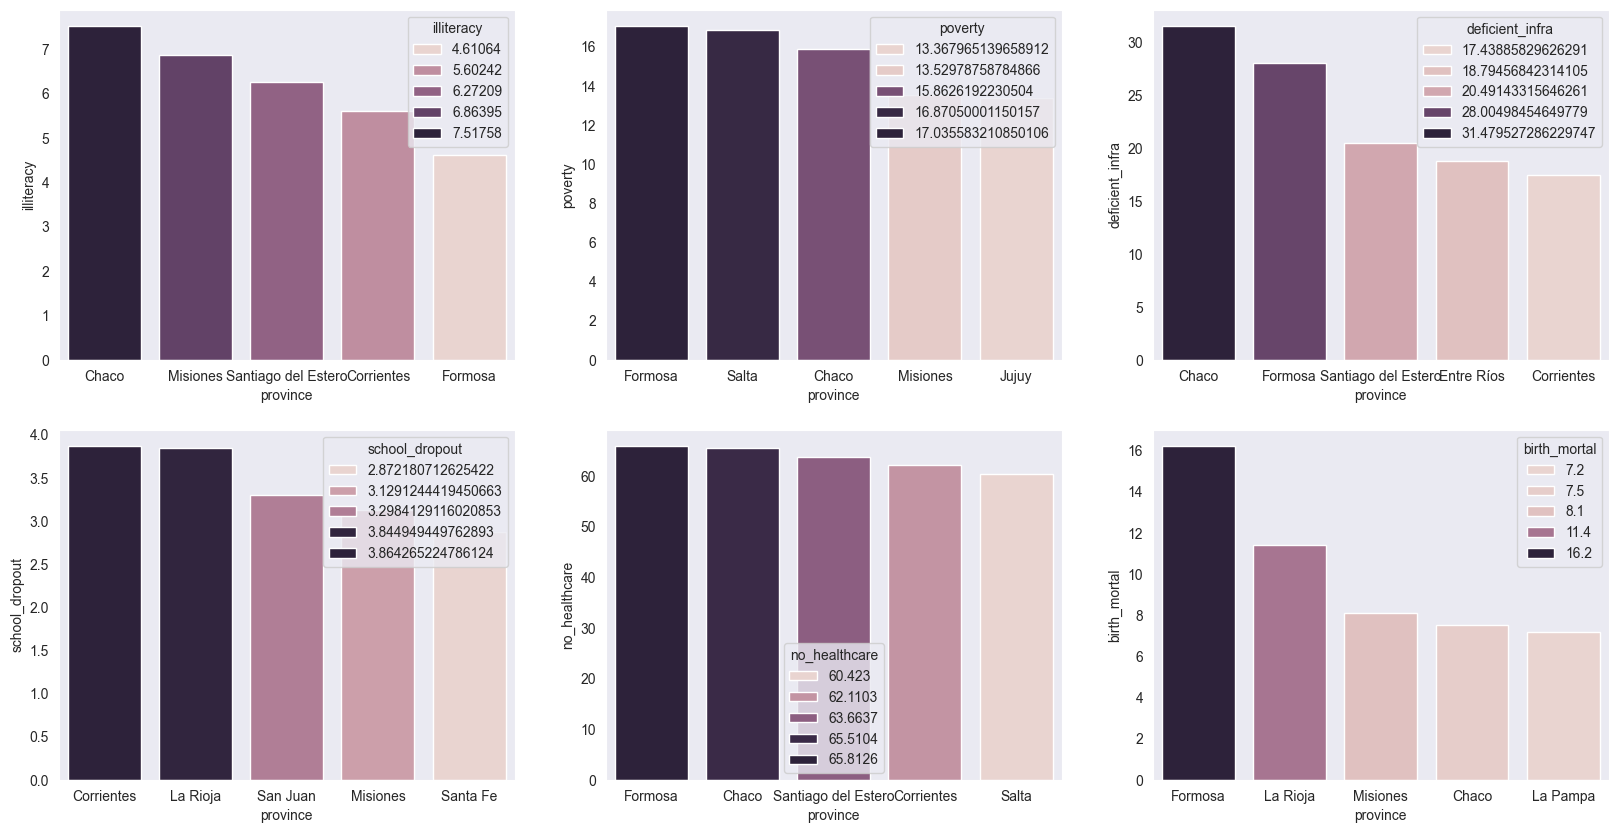

In [137]:
variables = ['illiteracy', 'poverty', 'deficient_infra', 
             'school_dropout', 'no_healthcare', 'birth_mortal']

create_graphic_grid(df=df, fixed_variable='province', variables=variables, ascending=False)

<h3>2.3 Top 5 best provinces in each numerical variable</h3>

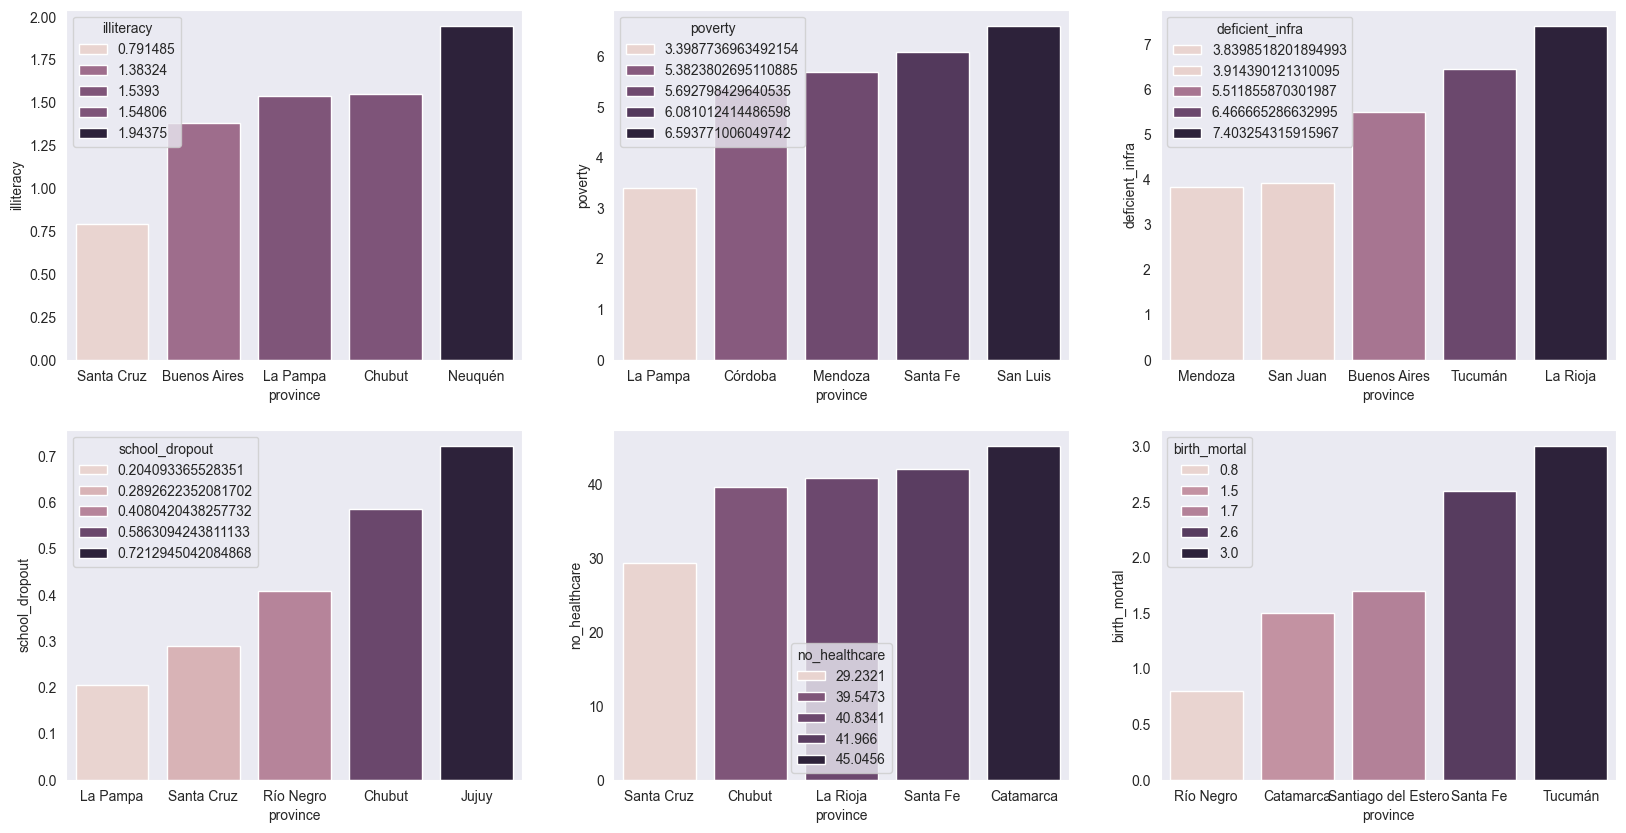

In [138]:
create_graphic_grid(df=df, fixed_variable='province', variables=variables, ascending=True)

<h3>2.4 Correlation Heatmap</h3>

Shows which variables are correlated

<img src="./sources/correlation.png">

Conclusions

- When children|adults decide to leave school (school_dropout) for different reasons, illiteracy increases.
- The gross domestic product (GDP) increses when the population increses too.
- Many people don't have access to education because they don't have healthcare.

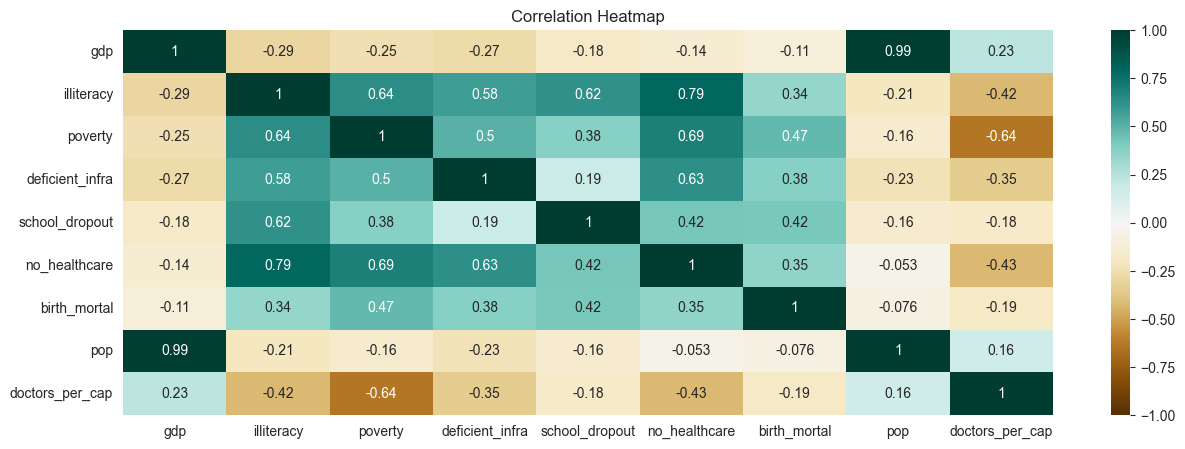

In [139]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(numerical_columns.corr(), ax=ax, cmap='BrBG', annot=True, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

<h3>Population percentage</h3>

In [140]:
total_argentina_population = df.loc[:, 'pop'].sum()

df['pop_percentage'] = df.loc[:, 'pop'].apply(lambda x: x / total_argentina_population)

In [141]:
df.loc[:, ['province', 'pop_percentage']].sort_values(
    by='pop_percentage', ascending=False, ignore_index=True).head()

,province,pop_percentage
0,Buenos Aires,0.42
1,Córdoba,0.09
2,Santa Fe,0.09
3,Mendoza,0.05
4,Tucumán,0.04


<h3>2.5 Clustering provinces with K-means</h3>

In [142]:
n_clusters = [n for n in range(1, 8)]
inertia_values = []

for n in n_clusters:
    kmeans_model = KMeans(n_clusters=n, random_state=0)
    kmeans_model.fit(numerical_columns)
    inertia_values.append(kmeans_model.inertia_)

In [143]:
inertia_values

[8.050222496673763e+16,
 8312981607358470.0,
 1018411845300752.2,
 337632696306724.8,
 208615413305911.8,
 133884162065348.03,
 47837754335317.08]

<Axes: >

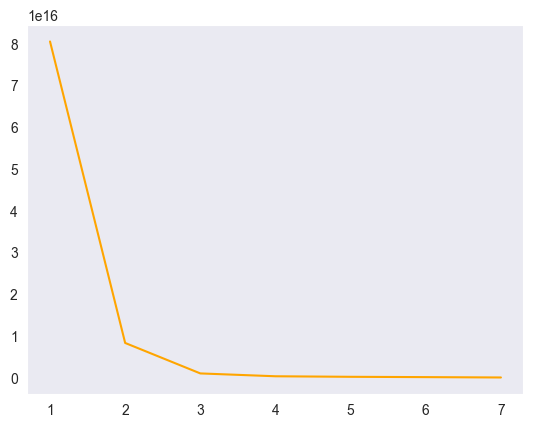

In [144]:
# Elbow Method (Graphic) -> Best n_clusters = 3

sns.lineplot(x=n_clusters, y=inertia_values, color='orange')

In [145]:
kmeans_model = KMeans(n_clusters=3, random_state=0)

In [146]:
kmeans_model.fit(numerical_columns)

KMeans(n_clusters=3, random_state=0)

In [147]:
df['kmeans_cluster'] = kmeans_model.predict(numerical_columns)

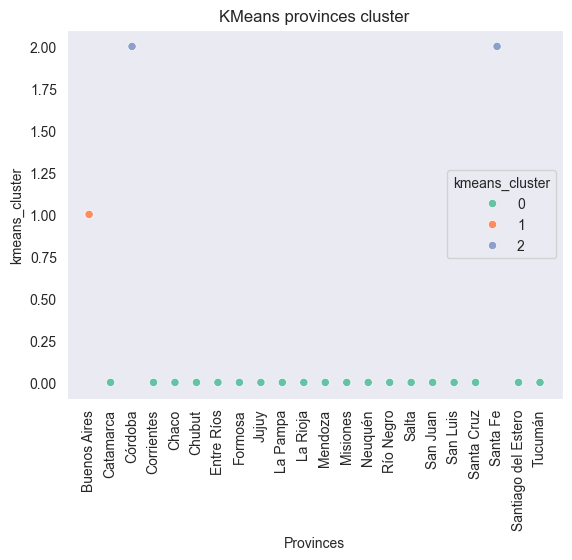

In [148]:
sns.scatterplot(data=df, x='province', y='kmeans_cluster', hue='kmeans_cluster', palette='Set2')
plt.title("KMeans provinces cluster")
plt.xlabel("Provinces")
plt.tick_params(axis='x', labelrotation=90)
plt.show()

In [149]:
for i in df['kmeans_cluster'].unique():
    print(f"Cluster {i}: {df.loc[df['kmeans_cluster'] == i, ['province']].values}")

Cluster 1: [['Buenos Aires']]
Cluster 0: [['Catamarca']
 ['Corrientes']
 ['Chaco']
 ['Chubut']
 ['Entre Ríos']
 ['Formosa']
 ['Jujuy']
 ['La Pampa']
 ['La Rioja']
 ['Mendoza']
 ['Misiones']
 ['Neuquén']
 ['Río Negro']
 ['Salta']
 ['San Juan']
 ['San Luis']
 ['Santa Cruz']
 ['Santiago del Estero']
 ['Tucumán']]
Cluster 2: [['Córdoba']
 ['Santa Fe']]


Conclusions:

- Best k for clustering is 3 using the elbow method
- Cluster 0 (Poor provinces), cluster 1 (Buenos Aires), cluster 2 (Rich provinces)

In [150]:
df.select_dtypes(exclude='object').groupby(by='kmeans_cluster').mean()

,gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,doctors_per_cap,gdp_per_capita,pop_percentage
kmeans_cluster,,,,,,,,,,,
0,12032227.16,3.42,10.46,13.21,1.75,51.60,5.15,787960.16,0.00,17.81,0.02
1,292689867.99,1.38,8.17,5.51,0.77,48.79,4.40,15625084.00,0.00,18.73,0.42
2,75476214.73,2.35,5.73,11.15,1.95,43.87,3.70,3251706.50,0.01,23.25,0.09


<h2>3. Geospatial Analysis</h2>

Geospatial analysis is a powerful tool for visualizing the relationship in our data. Humans are better able to recognize patterns using vision.

In [151]:
provinces_gdf = gpd.read_file('./ProvinciasArgentina.geojson')
provinces_gdf.head(n=5)

,nombre,geometry
0,Tucumán,"POLYGON ((-66.20361 -26.62782, -66.04980 -26.6..."
1,Santiago del Estero,"POLYGON ((-64.42108 -26.28356, -65.03906 -27.8..."
2,Salta,"POLYGON ((-66.11572 -26.21459, -65.85205 -26.3..."
3,Jujuy,"POLYGON ((-67.22534 -23.69483, -66.47827 -24.2..."
4,Formosa,"POLYGON ((-62.35840 -24.08659, -58.40332 -26.8..."


In [152]:
provinces_gdf.rename(columns={'nombre': 'province'}, inplace=True)

<h3>3.1 Joining data</h3>

In [153]:
data_joined = pd.merge(df, provinces_gdf, how='inner', on='province')

provinces_gdf = gpd.GeoDataFrame(data=data_joined, geometry='geometry')

<Axes: >

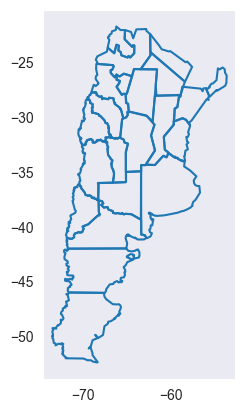

In [154]:
provinces_gdf.boundary.plot()

<h3>3.2 Heatmaps about each numerical variable</h3>

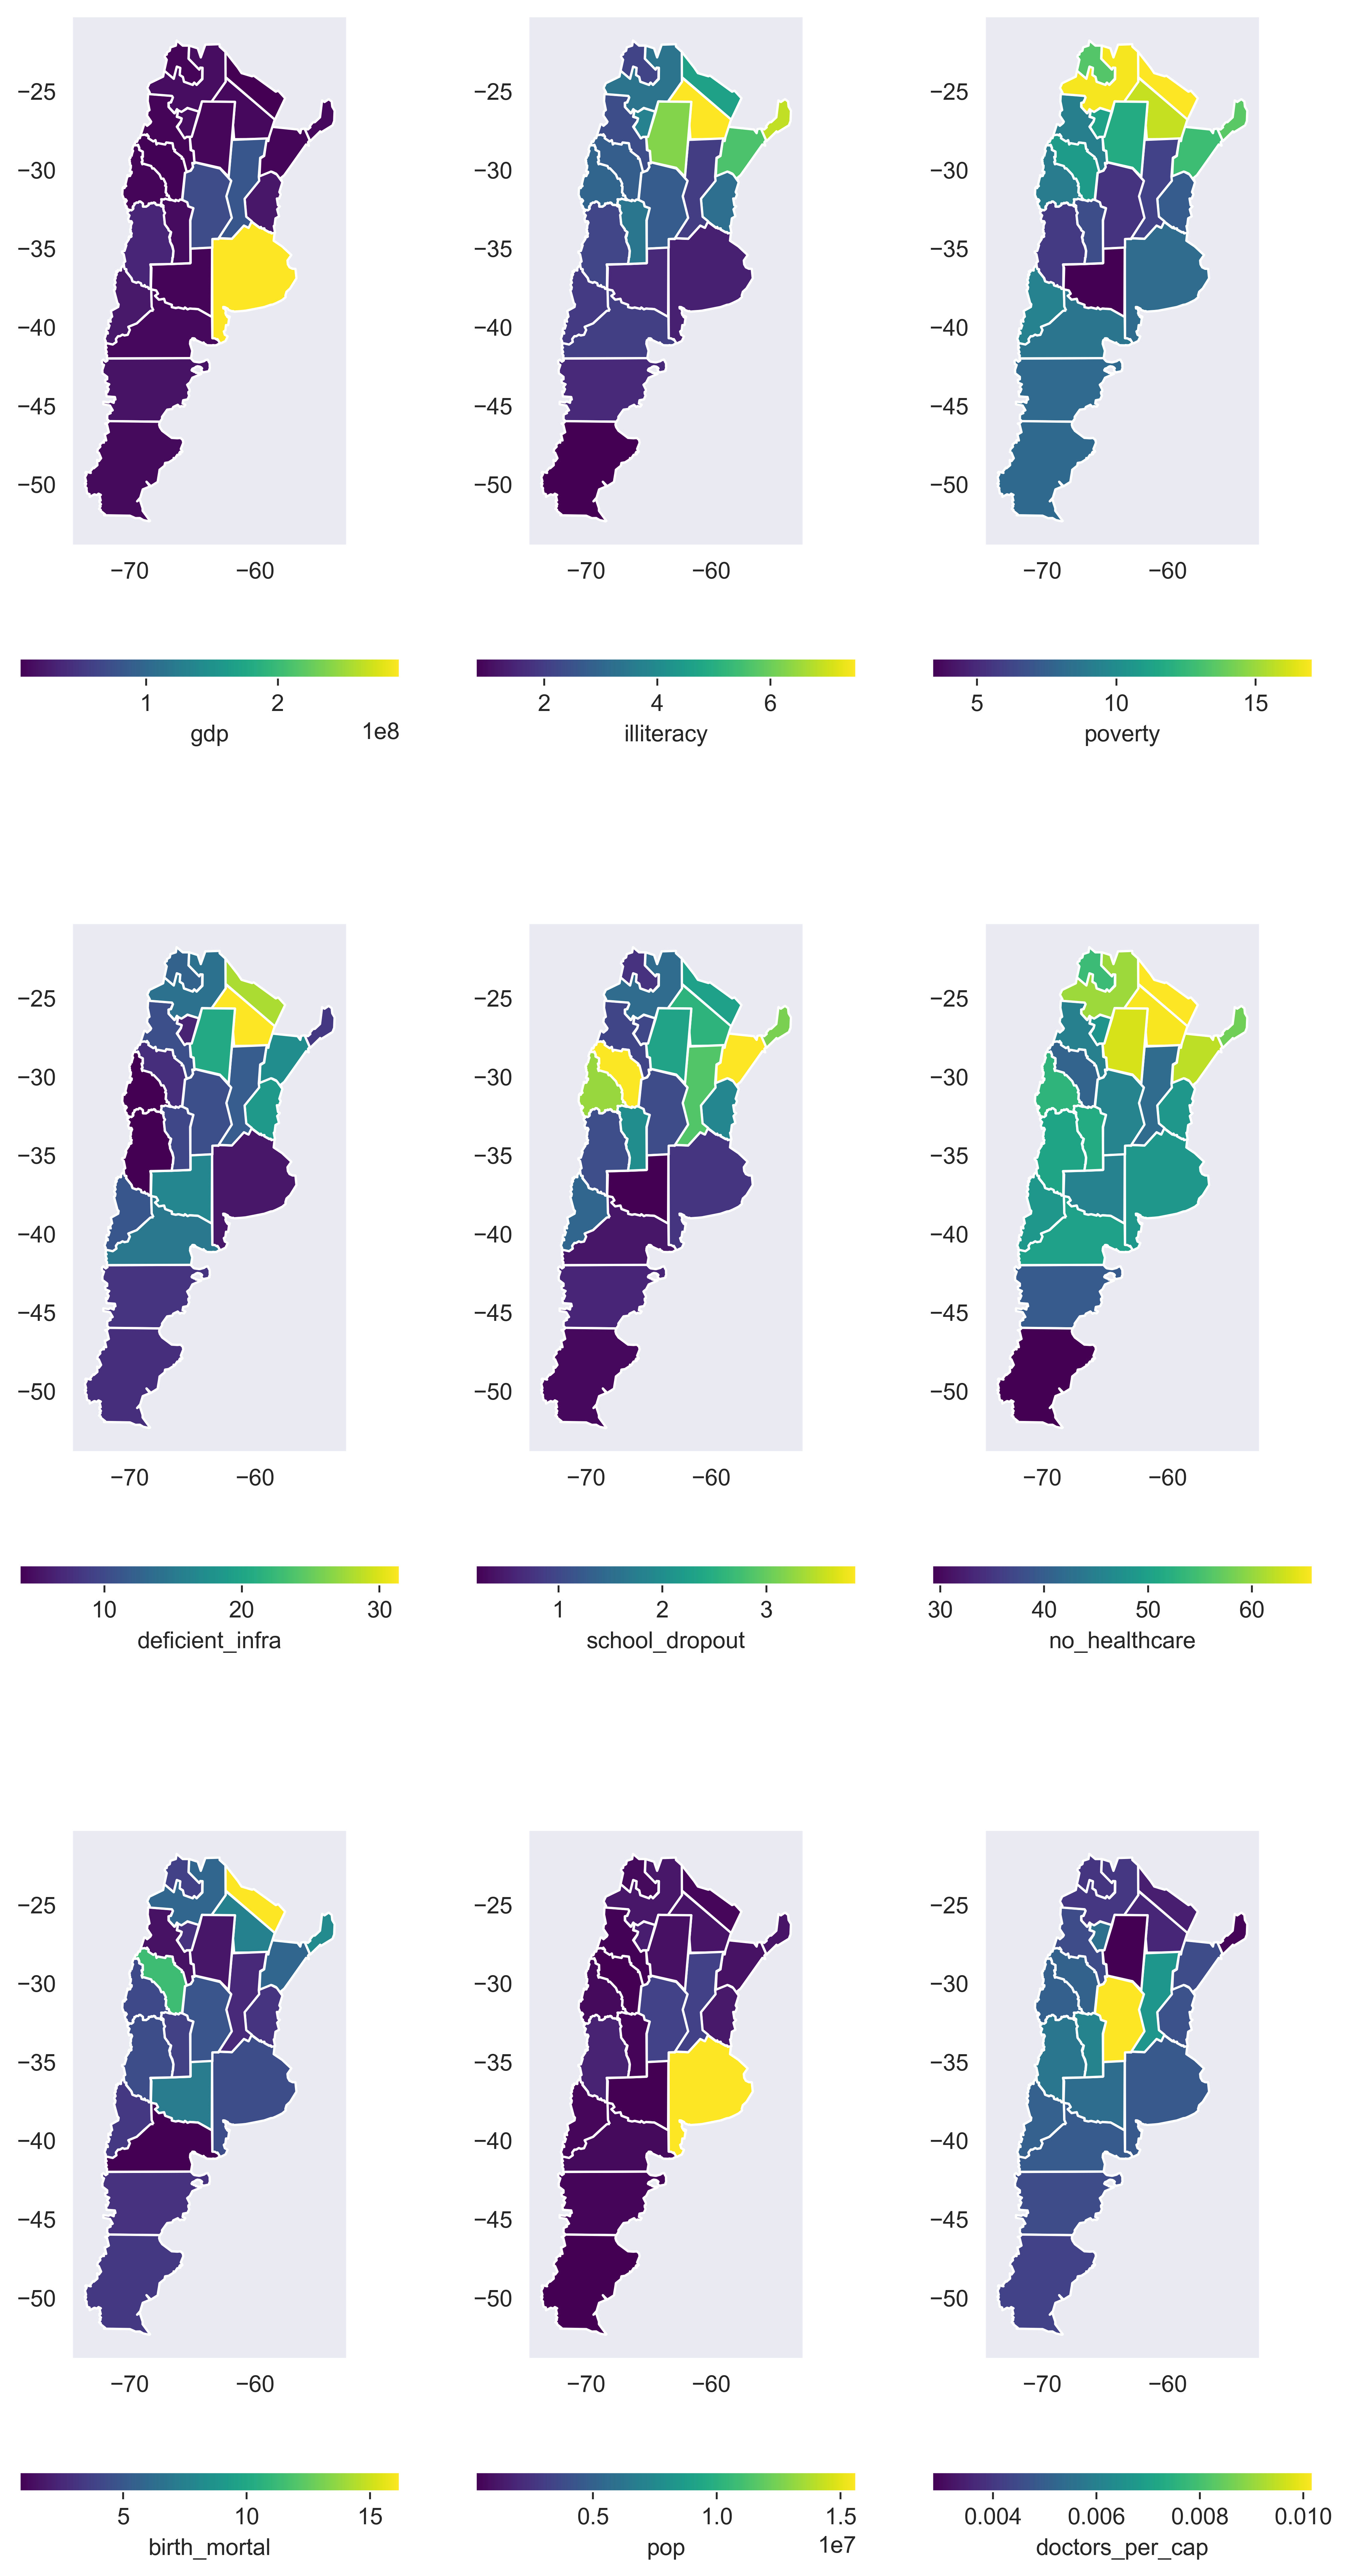

In [169]:
def create_heatmap(gdf: gpd.GeoDataFrame, numerical_variables: list, grid: tuple):
    fig, ax = plt.subplots(grid[0], grid[1], dpi=500, figsize=(10,20))
    for index, n_variable in enumerate(numerical_variables):
        row = index // grid[1]
        col = index % grid[1]
        provinces_gdf.plot(
            ax=ax[row][col],
            column=n_variable,
            legend=True,
            legend_kwds={"label": n_variable, "orientation": "horizontal"},
            cmap='viridis')

create_heatmap(gdf=provinces_gdf, numerical_variables=numerical_columns, grid=[3,3])